In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pwd
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/M5/week5")
!ls
!pwd

/content
Detectron2_kitti_coco_cityscapes2.ipynb
Detectron2_kitti_coco_cityscapes_change_LR.ipynb
Detectron2_kitti_coco_cityscapes_eval_pre_trained.ipynb
Detectron2_kitti_coco_cityscapes_ori.ipynb
Detectron2_kitti_coco_cityscapes_resize.ipynb
Detectron2_kitti_coco_cityscapes_resize.ipynb（副本）
exmaple_list.pkl
output_change_LR
output_ori
output_resize
output_test
training_validation.pkl
/content/drive/My Drive/Colab Notebooks/M5/week5


In [0]:
output_path = "./output_resize/"

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Install detectron2

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-pd5xf0hc
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-pd5xf0hc
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275362 sha256=a48d9ac226a3e5c5e917ce634db7f1b63adb4b35e3b4cb5fe369b857ec1d9552
  Stored in directory: /tmp/pip-ephem-wheel-cache-advvjgx4/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software F

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


# import

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
import tensorflow
tensorflow.__version__

'1.15.2'

# Train on my dataset

generate the lines of training and validation, and save pkl.
if not, load pkl

In [0]:
# import os
# def read_gt_txt(gt_txt, gt_path):
#     gt_index_str = gt_txt.split(".")[0]
#     gt_file = "{}{}".format(gt_path, gt_txt)
#     gt = []
#     gt_one_frame = []
#     time_frame_last = 0
#     for line in open(gt_file):
#         fields = line.split()
#         time_frame = int(fields[0])

#         one_instance = [gt_index_str]
#         one_instance.extend(fields)

#         # print(instance)
#         if time_frame == time_frame_last:
#             gt_one_frame.append(one_instance)
#         else:
#             gt.append(gt_one_frame)
#             # if time_frame != len(gt):
#             #     #raise Exception("time_frame != len(gt)")
#             #     print("error")
#             gt_one_frame = []
#             gt_one_frame.append(one_instance)

#         time_frame_last = time_frame

#     if len(gt_one_frame) > 0:
#         gt.append(gt_one_frame)

#     return gt



# gt_path = "../../KITTI-MOTS/instances_txt/"
# gt_all = []
# for gt_id, gt_txt in enumerate(sorted(os.listdir(gt_path))):
#     gt = read_gt_txt(gt_txt, gt_path)
#     gt_all.extend(gt)


In [0]:
# from random import shuffle
# shuffle(gt_all)
# train_ratio = 0.8
# training = gt_all[:int(len(gt_all)*train_ratio)]
# validation = gt_all[-int(len(gt_all)*(1.0 - train_ratio) + 1):] 

# import pickle
# with open("training_validation.pkl", 'wb') as f:
#     pickle.dump([training, validation], f)
#     f.close()

load pkl

In [0]:
import pickle
with open("training_validation.pkl", 'rb') as p:
    training, validation = pickle.load(p)
    p.close()

In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import numpy as np
import json
from detectron2.structures import BoxMode
from pycocotools.mask import toBbox, decode
import cv2


def register_from_dataset(dataset_path, dataset):

    dataset_dicts = []
    for idx, v in enumerate(dataset):
        instance_0 = v[0]
        record = {}

        filename = "{}/{}/{}.png".format(dataset_path, instance_0[0], instance_0[1].zfill(6))

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = int(instance_0[4])
        record["width"] = int(instance_0[5])

        objs = []
        for instance in v:
            # do like https://github.com/VisualComputingInstitute/mots_tools/blob/master/mots_common/io.py,
            # mask = {'size': [int(fields[3]), int(fields[4])], 'counts': fields[5].encode(encoding='UTF-8')}
            mask_rle = {'size': [int(instance[4]), int(instance[5])], 'counts': instance[6].encode(encoding='UTF-8')}
            box = toBbox(mask_rle)
            
            #convert rle to poly
            mask = decode(mask_rle)
            # https://github.com/facebookresearch/Detectron/issues/100  Sundrops
            # opencv 3.2
            # mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # before opencv 3.2
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            if len(segmentation) == 0:
                continue
            #End: convert rle to poly
            # print (segmentation)

            ori_class = int(instance[3])
            if ori_class == 1:
                transform_class = 0
            elif ori_class == 2:
                transform_class = 1
            else:
                # transform_class = 2
                continue

            obj = {
                "bbox": [box[0], box[1], box[0] + box[2], box[1] + box[3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": segmentation,
                "category_id": transform_class,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_path = "../../KITTI-MOTS/training/image_02"
# thing_classes = ['Car', 'Pedestrian', 'DontCare']
thing_classes = ['Car', 'Pedestrian']

# g = lambda: register_from_dataset(dataset_path, training)
# g()





In [0]:
DatasetCatalog.register("KITTI_MOTS_training", lambda: register_from_dataset(dataset_path, training))
MetadataCatalog.get("KITTI_MOTS_training").set(thing_classes=thing_classes)
DatasetCatalog.register("KITTI_MOTS_val", lambda: register_from_dataset(dataset_path, validation))
MetadataCatalog.get("KITTI_MOTS_val").set(thing_classes=thing_classes)

KITTI_MOTS_metadata = MetadataCatalog.get("KITTI_MOTS_training")

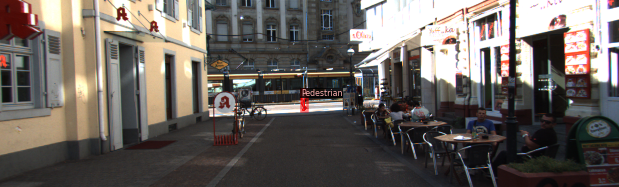

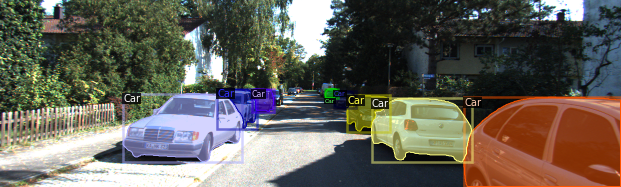

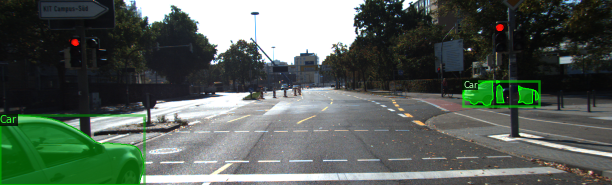

In [0]:
dataset_dicts = register_from_dataset(dataset_path, training)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=KITTI_MOTS_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [0]:
# reference https://detectron2.readthedocs.io/tutorials/data_loading.html
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
import copy

def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    image, transforms = T.apply_transform_gens([T.Resize((187, 621))], image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# data_loader = build_detection_train_loader(cfg, mapper=mapper)
# use this dataloader instead of the default

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# model_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
model_name = "Cityscapes/mask_rcnn_R_50_FPN.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_name))
cfg.DATASETS.TRAIN = ("KITTI_MOTS_training",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupMultiStepLR'   # 'WarmupMultiStepLR' (default) or 'WarmupCosineLR'
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)

cfg.OUTPUT_DIR = output_path


In [0]:
cfg.OUTPUT_DIR

'./output_resize/'

In [0]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)

[03/29 20:25:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (9, 1024) in the checkpoint but (3, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (9,) in the checkpoint but (3,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (32, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (32,) in the checkpoint but (8,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (8, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (8,) in the checkpoint but (2,) in the model! Skipped.


In [0]:
trainer.train()

[03/29 20:26:17 d2.engine.train_loop]: Starting training from iteration 0
[03/29 20:26:20 d2.utils.events]:  eta: 0:23:02  iter: 19  total_loss: 2.938  loss_cls: 1.102  loss_box_reg: 0.874  loss_mask: 0.694  loss_rpn_cls: 0.157  loss_rpn_loc: 0.130  time: 0.1390  data_time: 0.0148  lr: 0.000005  max_mem: 998M
[03/29 20:26:23 d2.utils.events]:  eta: 0:22:51  iter: 39  total_loss: 2.897  loss_cls: 1.063  loss_box_reg: 0.877  loss_mask: 0.690  loss_rpn_cls: 0.137  loss_rpn_loc: 0.128  time: 0.1381  data_time: 0.0049  lr: 0.000010  max_mem: 998M
[03/29 20:26:26 d2.utils.events]:  eta: 0:22:53  iter: 59  total_loss: 2.788  loss_cls: 0.988  loss_box_reg: 0.841  loss_mask: 0.684  loss_rpn_cls: 0.142  loss_rpn_loc: 0.141  time: 0.1388  data_time: 0.0049  lr: 0.000015  max_mem: 998M
[03/29 20:26:28 d2.utils.events]:  eta: 0:22:52  iter: 79  total_loss: 2.691  loss_cls: 0.884  loss_box_reg: 0.833  loss_mask: 0.679  loss_rpn_cls: 0.125  loss_rpn_loc: 0.123  time: 0.1393  data_time: 0.0051  lr: 0.

In [0]:
# Look at training curves in tensorboard:
output_path_split = output_path.split('/')[-2]
print (output_path_split)
%load_ext tensorboard
# %tensorboard --logdir output
%tensorboard --logdir {output_path_split}

output_resize


Reusing TensorBoard on port 6007 (pid 5963), started 0:37:13 ago. (Use '!kill 5963' to kill it.)

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("KITTI_MOTS_val", )
predictor = DefaultPredictor(cfg)

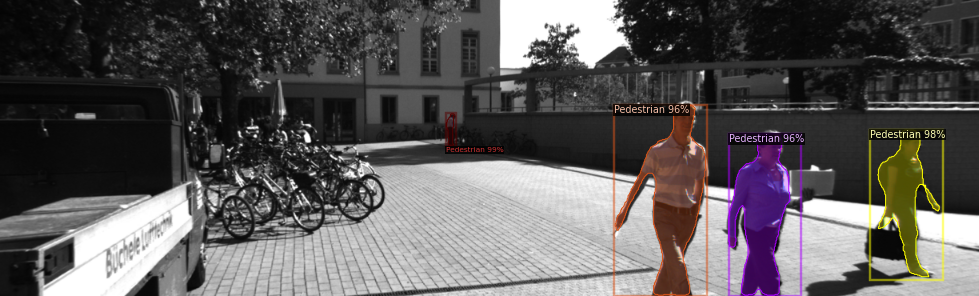

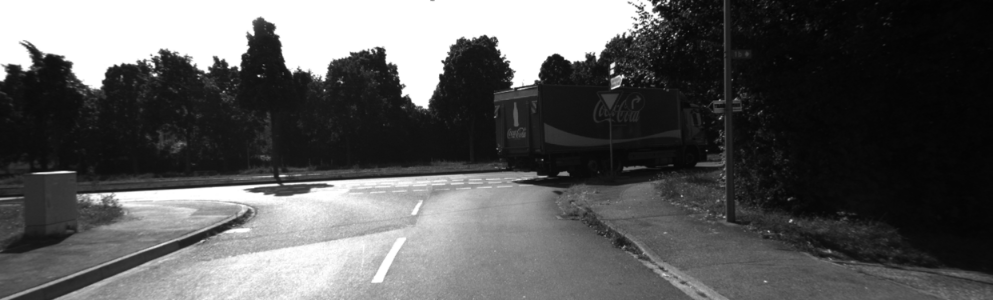

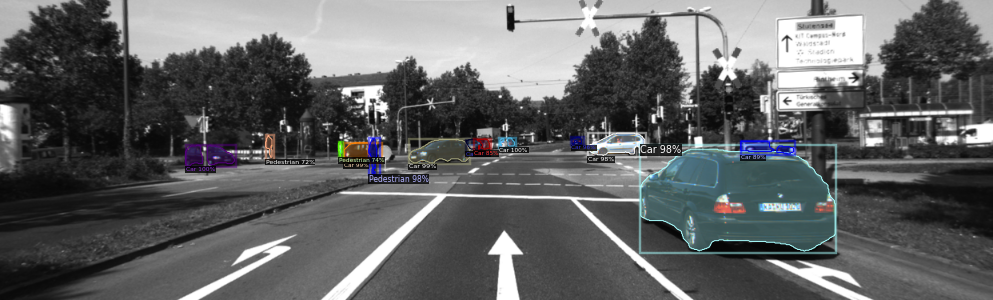

In [0]:
from detectron2.utils.visualizer import ColorMode
import pickle
dataset_dicts = register_from_dataset(dataset_path, validation)

# exmaple_list = random.sample(dataset_dicts, 3)
# with open("exmaple_list.pkl", 'wb') as f:
#     pickle.dump(exmaple_list, f)
#     f.close()
with open("exmaple_list.pkl", 'rb') as p:
    exmaple_list = pickle.load(p)
    p.close()

for d in exmaple_list:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=KITTI_MOTS_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

generate the corresponding ground truth

[{'file_name': '../../KITTI-MOTS/training/image_02/0017/000137.png', 'image_id': 32, 'height': 370, 'width': 1224, 'annotations': [{'bbox': [767.0, 127.0, 887.0, 370.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[769, 290, 768, 291, 767, 291, 768, 292, 768, 293, 769, 292], [850, 127, 846, 131, 846, 132, 843, 135, 843, 139, 842, 140, 842, 142, 841, 143, 841, 153, 842, 154, 842, 156, 843, 157, 843, 163, 841, 165, 841, 167, 839, 169, 839, 170, 838, 171, 837, 171, 836, 172, 836, 173, 834, 175, 833, 175, 831, 177, 830, 177, 829, 178, 828, 178, 827, 179, 825, 179, 824, 180, 823, 180, 822, 181, 820, 181, 818, 183, 817, 183, 815, 185, 815, 186, 813, 188, 813, 189, 812, 190, 812, 191, 811, 192, 810, 192, 810, 194, 809, 195, 809, 196, 808, 197, 808, 199, 807, 200, 807, 201, 806, 202, 806, 203, 805, 204, 805, 205, 804, 206, 804, 209, 803, 210, 803, 211, 802, 212, 802, 215, 801, 216, 801, 218, 800, 219, 800, 220, 798, 222, 798, 224, 797, 225, 797, 226, 796, 227, 796, 228, 794, 230, 794,

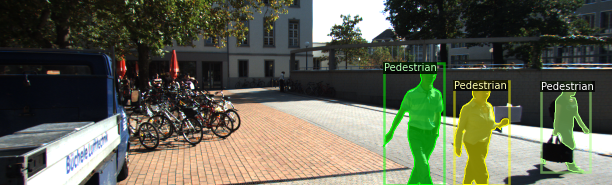

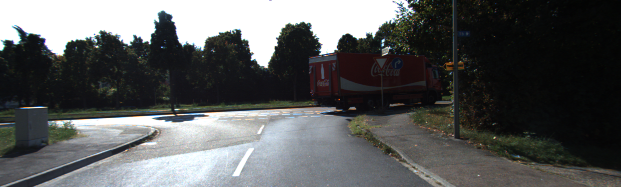

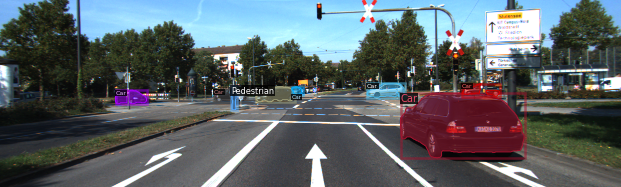

In [0]:
print (exmaple_list)
for d in exmaple_list:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=KITTI_MOTS_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("KITTI_MOTS_val", cfg, False, output_dir=output_path)
val_loader = build_detection_test_loader(cfg, "KITTI_MOTS_val", mapper=mapper)
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [03/29 20:49:43 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'KITTI_MOTS_val'. Trying to convert it to COCO format ...
[03/29 20:49:43 d2.data.datasets.coco]: Cached annotations in COCO format already exist: ./output_resize/KITTI_MOTS_val_coco_format.json
[03/29 20:49:55 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    Car     | 5227         | Pedestrian | 2383         |
|            |              |            |              |
|   total    | 7610         |            |              |
[03/29 20:49:55 d2.data.common]: Serializing 1586 elements to byte tensors and concatenating them all ...
[03/29 20:49:55 d2.data.common]: Serialized dataset takes 4.82 MiB
[03/29 20:49:55 d2.evaluation.evaluator]: Start inference on 1586 images
[03/29 20:49:58 d2.evaluation.evaluator]: Inference done 11/1586. 0.0349 s / img. ET

OrderedDict([('bbox',
              {'AP': 63.331607961792145,
               'AP-Car': 72.07420046234934,
               'AP-Pedestrian': 54.58901546123496,
               'AP50': 89.34691160117944,
               'AP75': 71.35272719320213,
               'APl': 79.49794375181935,
               'APm': 72.86638373422605,
               'APs': 48.36280423620801}),
             ('segm',
              {'AP': 48.88381265583637,
               'AP-Car': 65.08712359966081,
               'AP-Pedestrian': 32.68050171201191,
               'AP50': 81.43686539880673,
               'AP75': 49.82890333276574,
               'APl': 79.85998931479689,
               'APm': 58.483849976838144,
               'APs': 30.011821603027588})])